# ChEMBL Data Acquisition

Some notes on the theory:

 - IC50 is used for *inhibitors*
 - EC50 is used for *stimulators*

Confirmed [here](https://en.wikipedia.org/wiki/EC50).

In this tutorial, we will:

1. Connect to the ChEMBL database.
2. Gather *target* data. That is, data regarding a particular protein that we would like to activate or deactivate.
3. Gather *bioactivity* and *compound* data, and merge these into a single table describing the properties and bioactivities of various compounds.

### 1. Connect to the ChEMBL database

First, we set up a new client for connecting to ChEMBL.

In [1]:
from chembl_webresource_client.new_client import new_client

targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

### 2. Identify the Target Protein

Now, we define a variable to store the UniProt ID for the target protein of interest: EGFR kinase (UniProt ID P00533, see [here](https://www.uniprot.org/uniprot/P00533)).

In [2]:
uniprot_id = "P00533"

Next, we search ChEMBL for this target.
The `.only()` command here narrows the table returned from ChEMBL to only include certain collumns.

In [3]:
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
type(targets)

chembl_webresource_client.query_set.QuerySet

Now, we convert the values returned from ChEMBL into a pandas dataframe.
The original `targets` record is a `QuerySet` object -- that is it is a description of a particular type of *search* on the ChEMBL database, that doesn't return the *results* of that search until we ask it to.

Converting to a DataFrame here causes the search to be performed and stores the results in our pandas dataframe.

In [4]:
import pandas as pd

targets_df = pd.DataFrame.from_records(targets)
targets_df

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Epidermal growth factor receptor erbB1,CHEMBL203,SINGLE PROTEIN
1,Homo sapiens,Epidermal growth factor receptor erbB1,CHEMBL203,SINGLE PROTEIN
2,Homo sapiens,Epidermal growth factor receptor and ErbB2 (HE...,CHEMBL2111431,PROTEIN FAMILY
3,Homo sapiens,Epidermal growth factor receptor,CHEMBL2363049,PROTEIN FAMILY
4,Homo sapiens,MER intracellular domain/EGFR extracellular do...,CHEMBL3137284,CHIMERIC PROTEIN
5,Homo sapiens,Protein cereblon/Epidermal growth factor receptor,CHEMBL4523680,PROTEIN-PROTEIN INTERACTION
6,Homo sapiens,EGFR/PPP1CA,CHEMBL4523747,PROTEIN-PROTEIN INTERACTION
7,Homo sapiens,VHL/EGFR,CHEMBL4523998,PROTEIN-PROTEIN INTERACTION


These are all of the search results matching our query.
We only care about the first one, so we can select it from the DataFrame using [the `iloc` method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html).

In [5]:
target = targets_df.iloc[0]
target

organism                                      Homo sapiens
pref_name           Epidermal growth factor receptor erbB1
target_chembl_id                                 CHEMBL203
target_type                                 SINGLE PROTEIN
Name: 0, dtype: object

Now, save the ChEMBL ID for the target, which can be seen above.
Specific entries from a row can be accessed either as
```
target.<column name>
```
or as
```
target["column name"]
```

In [6]:
chembl_id = target["target_chembl_id"]
print(chembl_id)
# ^ this does the same thing as this:
chembl_id = target.target_chembl_id
print(chembl_id)

CHEMBL203
CHEMBL203


### 3. Find Bioactivities for the Target Protein

Next, we are going to search for bioactivity data, only considering human proteins with bioactivity type IC50.
I believe that if we were looking for a drug that stimulates rather than inhibits a protein, we would be looking for EC50 here.
The `assay_type="B"` argument says that we are looking for binding data, i.e. data measuring the binding of a compound to a molecular target.
Other assay types can be found [here](https://chembl.gitbook.io/chembl-interface-documentation/frequently-asked-questions/general-questions#what-is-the-assay-type).

Again, we filter the resulting query values to only include certain columns.

In [7]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id,
    type="IC50",
    relation="=",
    assay_type="B",
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

Note that we have included the following among our requested columns:
 - The standard units used for measuring IC50.
 - The value of the IC50 in these units.
 - The target organism (we are interested in Homo sapiens).
Including standard units and values ensures that we can compare IC50s directly.

Let's print the first two results from this query.

In [8]:
print("First result:")
print(bioactivities[0])
print("\nSecond result:")
print(bioactivities[1])

First result:
{'activity_id': 32260, 'assay_chembl_id': 'CHEMBL674637', 'assay_description': 'Inhibitory activity towards tyrosine phosphorylation for the epidermal growth factor-receptor kinase', 'assay_type': 'B', 'molecule_chembl_id': 'CHEMBL68920', 'relation': '=', 'standard_units': 'nM', 'standard_value': '41.0', 'target_chembl_id': 'CHEMBL203', 'target_organism': 'Homo sapiens', 'type': 'IC50', 'units': 'uM', 'value': '0.041'}

Second result:
{'activity_id': 32267, 'assay_chembl_id': 'CHEMBL674637', 'assay_description': 'Inhibitory activity towards tyrosine phosphorylation for the epidermal growth factor-receptor kinase', 'assay_type': 'B', 'molecule_chembl_id': 'CHEMBL69960', 'relation': '=', 'standard_units': 'nM', 'standard_value': '170.0', 'target_chembl_id': 'CHEMBL203', 'target_organism': 'Homo sapiens', 'type': 'IC50', 'units': 'uM', 'value': '0.17'}


Now, again, let's store the result of this query to a pandas DataFrame.

We can use [the `.head()` method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html) to return only the first `n` rows of the DataFrame.

In [9]:
bioactivities_df = pd.DataFrame.from_records(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head(n=10)

DataFrame shape: (8817, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50,uM,0.17
1,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50,uM,0.041
2,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50,uM,0.17
3,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50,uM,9.3
4,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50,uM,500.0
5,32772,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL66879,=,nM,3000000.0,CHEMBL203,Homo sapiens,IC50,uM,3000.0
6,32780,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL77085,=,nM,96000.0,CHEMBL203,Homo sapiens,IC50,uM,96.0
7,33406,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL443268,=,nM,5310.0,CHEMBL203,Homo sapiens,IC50,uM,5.31
8,34039,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL76979,=,nM,264000.0,CHEMBL203,Homo sapiens,IC50,uM,264.0
9,34041,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL76589,=,nM,125.0,CHEMBL203,Homo sapiens,IC50,uM,0.125


Since we have standard units and values, we can drop the compound-specific units and values from the table using the .drop() method:

In [10]:
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head(n=10)

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50
1,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50
2,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50
3,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50
4,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50
5,32772,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL66879,=,nM,3000000.0,CHEMBL203,Homo sapiens,IC50
6,32780,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL77085,=,nM,96000.0,CHEMBL203,Homo sapiens,IC50
7,33406,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL443268,=,nM,5310.0,CHEMBL203,Homo sapiens,IC50
8,34039,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL76979,=,nM,264000.0,CHEMBL203,Homo sapiens,IC50
9,34041,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL76589,=,nM,125.0,CHEMBL203,Homo sapiens,IC50


Note that the bioactivity values are stored as strings, and all of the column types are `object`:

In [11]:
bioactivities_df.dtypes

activity_id            int64
assay_chembl_id       object
assay_description     object
assay_type            object
molecule_chembl_id    object
relation              object
standard_units        object
standard_value        object
target_chembl_id      object
target_organism       object
type                  object
dtype: object

We want to convert the values to `float`s (numbers) so that we can do math with them later on.
To do convert column types, we use the `.astype()` method.

In [12]:
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
bioactivities_df.dtypes

activity_id             int64
assay_chembl_id        object
assay_description      object
assay_type             object
molecule_chembl_id     object
relation               object
standard_units         object
standard_value        float64
target_chembl_id       object
target_organism        object
type                   object
dtype: object

Now, we will drop missing entries (entries without a known activity value) from the table.
Using `axis=0` here specifies that we want to search for missing values by row, and `how="any"` specifies that rows in which any value is missing will be dropped.

If we print the updated shape, we will see that we have two fewer columns (because we dropped `"value"` and `"units"` above) and perhaps also fewer rows, if some of them had missing entries.

In [13]:
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (8816, 11)


Next, we filter out entries where the standard units are something other than `"nM"`.
If `df` is our DataFrame and we want to select rows with a particular column value, the syntax is as follows:
```
df[df["<column name>"] == <column value>]
```

In [14]:
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (8747, 11)


Next, we delete duplicates (molecules which have been tested more than once will appear multiple times).

We identify duplicates based on the `"molecule_chembl_id"` column.

In [15]:
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (6059, 11)


After deleting some rows, the row index for the table currently skips values.
To make it easier to work with, we will reset the index.

In [16]:
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.head(n=10)

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50
1,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50
2,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50
3,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50
4,32772,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL66879,=,nM,3000000.0,CHEMBL203,Homo sapiens,IC50
5,32780,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL77085,=,nM,96000.0,CHEMBL203,Homo sapiens,IC50
6,33406,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL443268,=,nM,5310.0,CHEMBL203,Homo sapiens,IC50
7,34039,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL76979,=,nM,264000.0,CHEMBL203,Homo sapiens,IC50
8,34041,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL76589,=,nM,125.0,CHEMBL203,Homo sapiens,IC50
9,34049,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL76904,=,nM,35000.0,CHEMBL203,Homo sapiens,IC50


Now, we're going to rename the value and units columns to have more meaningful column names.

In [17]:
bioactivities_df.rename(
    columns={
        "standard_value": "IC50",
        "standard_units": "units"
    },
    inplace=True
)
bioactivities_df.head(n=10)

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50
1,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50
2,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50
3,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50
4,32772,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL66879,=,nM,3000000.0,CHEMBL203,Homo sapiens,IC50
5,32780,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL77085,=,nM,96000.0,CHEMBL203,Homo sapiens,IC50
6,33406,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL443268,=,nM,5310.0,CHEMBL203,Homo sapiens,IC50
7,34039,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL76979,=,nM,264000.0,CHEMBL203,Homo sapiens,IC50
8,34041,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL76589,=,nM,125.0,CHEMBL203,Homo sapiens,IC50
9,34049,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL76904,=,nM,35000.0,CHEMBL203,Homo sapiens,IC50


### 4. Find Compound Data

Our bioactivity dataframe identifies all molecules tested for activity on EGFR, but it is missing additional information about the molecules.

The following query searches the database for molecules in a list, where we set the list based on the list of molecules in our bioactivities DataFrame:

In [18]:
compounds = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only(
    "molecule_chembl_id",
    "molecule_structures",
)

This query takes a long time, so we make a progress bar using tqdm:

In [19]:
from tqdm.auto import tqdm

compounds_list = list(tqdm(compounds))

  0%|          | 0/6059 [00:00<?, ?it/s]

Once that downloads, we convert it to a DataFrame:

In [20]:
compounds_df = pd.DataFrame.from_records(
    compounds_list,
)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (6059, 2)


Let's see what this table looks like:

In [21]:
compounds_df.head(n=10)

,molecule_chembl_id,molecule_structures
0,CHEMBL6246,{'canonical_smiles': 'O=c1oc2c(O)c(O)cc3c(=O)o...
1,CHEMBL10,{'canonical_smiles': 'C[S+]([O-])c1ccc(-c2nc(-...
2,CHEMBL6976,{'canonical_smiles': 'COc1cc2c(cc1OC)Nc1ncn(C)...
3,CHEMBL7002,{'canonical_smiles': 'CC1(COc2ccc(CC3SC(=O)NC3...
4,CHEMBL414013,{'canonical_smiles': 'COc1cc2c(cc1OC)Nc1ncnc(O...
5,CHEMBL7866,{'canonical_smiles': 'COC(=O)Cn1cc(-c2cccc(Cl)...
6,CHEMBL44,{'canonical_smiles': 'O=c1c(-c2ccc(O)cc2)coc2c...
7,CHEMBL7810,{'canonical_smiles': 'COc1cc(O)c2c(=O)c(-c3ccc...
8,CHEMBL268868,{'canonical_smiles': 'O=C1NC(=O)c2cc(Nc3ccccc3...
9,CHEMBL7339,{'canonical_smiles': 'COc1cc(O)c2c(=O)c(-c3ccc...


Again, we remove rows with missing data using the `.dropna()` function.

In [22]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (6052, 2)


And now we remove duplicates using the `.drop_duplicates()` function.

In [23]:
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (6052, 2)


Note above that the `"molecule_structures"` column contains dictionaries with different types of structural information ([SMILEs](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system), [InChI](https://en.wikipedia.org/wiki/International_Chemical_Identifier), [MolFile](https://en.wikipedia.org/wiki/Chemical_table_file), etc.).

In [24]:
compounds_df.iloc[0]["molecule_structures"].keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

This next step finds all of the structural information containing canonical SMILES strings and stores them to a new column called `"smiles"`.

Note that I am doing this a slightly different way from the talktorial, by mapping a function across the column rather than looping over it.

In [25]:
smiles_lst = []

def smiles_from_dict(mol_struct_dct):
    smiles = None
    if "canonical_smiles" in mol_struct_dct:
        smiles = mol_struct_dct["canonical_smiles"]
    return smiles

compounds_df["smiles"] = compounds_df["molecule_structures"].map(smiles_from_dict)

Now, we can drop the original `"molecular_structures"` column since the SMILES give us everything we need.

In [26]:
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (6052, 2)


Now we have a table of ChEMBL IDs and SMILES strings.

In [27]:
compounds_df.head(n=10)

,molecule_chembl_id,smiles
0,CHEMBL6246,O=c1oc2c(O)c(O)cc3c(=O)oc4c(O)c(O)cc1c4c23
1,CHEMBL10,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...
2,CHEMBL6976,COc1cc2c(cc1OC)Nc1ncn(C)c(=O)c1C2
3,CHEMBL7002,CC1(COc2ccc(CC3SC(=O)NC3=O)cc2)CCCCC1
4,CHEMBL414013,COc1cc2c(cc1OC)Nc1ncnc(O)c1C2
5,CHEMBL7866,COC(=O)Cn1cc(-c2cccc(Cl)c2)c(=O)c2c(O)cc(OC)cc21
6,CHEMBL44,O=c1c(-c2ccc(O)cc2)coc2cc(O)cc(O)c12
7,CHEMBL7810,COc1cc(O)c2c(=O)c(-c3cccc(Cl)c3)cn(CCc3ccccc3)...
8,CHEMBL268868,O=C1NC(=O)c2cc(Nc3ccccc3)c(Nc3ccccc3)cc21
9,CHEMBL7339,COc1cc(O)c2c(=O)c(-c3cccc(Cl)c3)coc2c1


### 5. Combine Bioactivity and Compound DataFrames

Above, we generated a DataFrame of bioactivities for specific molecules, by their ChEMBL IDs.
After that, we generated a DataFrame containing the SMILES strings for each of these bioactive compounds.

Now we wish to join these two tables, dropping any compounds for which we weren't able to get structural information (i.e. SMILES strings).

In [28]:
print(f"Bioactivities rows: {bioactivities_df.shape[0]}")
print("Bioactivities columns:")
bioactivities_df.columns

Bioactivities rows: 6059
Bioactivities columns:


Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'units', 'IC50', 'target_chembl_id',
       'target_organism', 'type'],
      dtype='object')

In [29]:
print(f"Compounds rows: {compounds_df.shape[0]}")
print("Compounds columns:")
compounds_df.columns

Compounds rows: 6052
Compounds columns:


Index(['molecule_chembl_id', 'smiles'], dtype='object')

We will join these two tables using [the `merge` method](https://pandas.pydata.org/docs/reference/api/pandas.merge.html?highlight=merge#pandas.merge), joining rows with matching ChEMBL IDs:

In [30]:
# Join the two DataFrames on the ChEMBL ID column
new_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset the row indices
new_df.reset_index(drop=True, inplace=True)

# Let this be the new compounds DataFrame
compounds_df = new_df

We can see that it worked by looking at the resulting DataFrame:

In [31]:
print(f"Compounds rows: {compounds_df.shape[0]}")
print("Compounds columns:")
compounds_df.columns

Compounds rows: 6052
Compounds columns:


Index(['molecule_chembl_id', 'IC50', 'units', 'smiles'], dtype='object')

In [32]:
compounds_df.head(n=10)

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL69960,170.0,nM,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...
1,CHEMBL68920,41.0,nM,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...
2,CHEMBL137635,9300.0,nM,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12
3,CHEMBL306988,500000.0,nM,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1
4,CHEMBL66879,3000000.0,nM,O=C(O)/C=C/c1ccc(O)cc1
5,CHEMBL77085,96000.0,nM,N#CC(C#N)=Cc1cc(O)ccc1[N+](=O)[O-]
6,CHEMBL443268,5310.0,nM,Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)N(C)c2...
7,CHEMBL76979,264000.0,nM,COc1cc(/C=C(\C#N)C(=O)O)cc(OC)c1O
8,CHEMBL76589,125.0,nM,N#CC(C#N)=C(N)/C(C#N)=C/c1ccc(O)cc1
9,CHEMBL76904,35000.0,nM,N#CC(C#N)=Cc1ccc(O)c(O)c1


We can now add pIC50 values, which are the negative log of the molar concentration.
Since the concentrations are in nM we subtract 9 from the log to have the log of M.

In [33]:
import numpy

def pic50_from_ic50(ic50):
    return -(numpy.log10(ic50) - 9)

compounds_df["pIC50"] = compounds_df["IC50"].map(pic50_from_ic50)

In [34]:
compounds_df.head(n=10)

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL69960,170.0,nM,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,6.769551
1,CHEMBL68920,41.0,nM,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,7.387216
2,CHEMBL137635,9300.0,nM,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12,5.031517
3,CHEMBL306988,500000.0,nM,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1,3.301030
4,CHEMBL66879,3000000.0,nM,O=C(O)/C=C/c1ccc(O)cc1,2.522879
5,CHEMBL77085,96000.0,nM,N#CC(C#N)=Cc1cc(O)ccc1[N+](=O)[O-],4.017729
6,CHEMBL443268,5310.0,nM,Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)N(C)c2...,5.274905
7,CHEMBL76979,264000.0,nM,COc1cc(/C=C(\C#N)C(=O)O)cc(OC)c1O,3.578396
8,CHEMBL76589,125.0,nM,N#CC(C#N)=C(N)/C(C#N)=C/c1ccc(O)cc1,6.903090
9,CHEMBL76904,35000.0,nM,N#CC(C#N)=Cc1ccc(O)c(O)c1,4.455932


Pandas makes it easy to create a histogram of our pIC50 values:

array([[<AxesSubplot:title={'center':'pIC50'}>]], dtype=object)

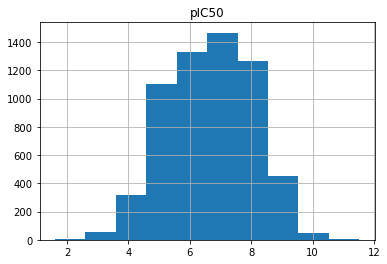

In [35]:
compounds_df.hist(column="pIC50")

Their approach with PandasTools didn't work for me (there seems to be an unresolved version conflict between Pandas and RDKit), so I'm doing this differently.

First, let's sort the table by pIC50:

In [36]:
# Sort DataFrame by pIC50 values
compounds_df.sort_values(by="pIC50", ascending=False, inplace=True)

# Reset index based on the new sort order
compounds_df.reset_index(drop=True, inplace=True)

Now, let's visualize the smiles for the top 10 molecules:

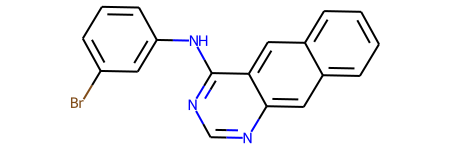

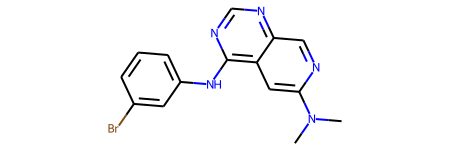

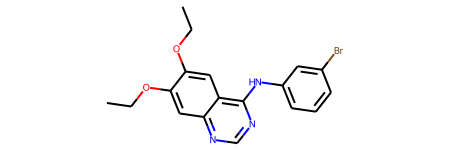

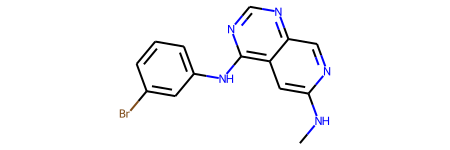

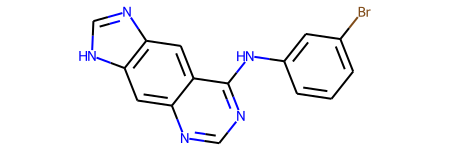

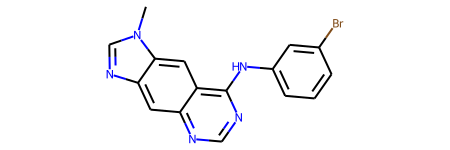

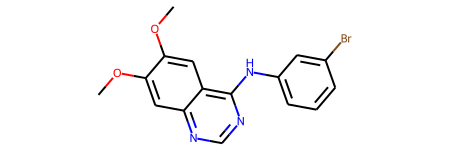

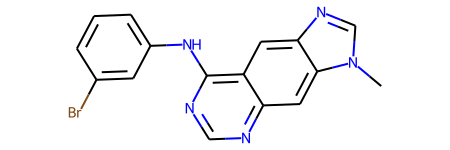

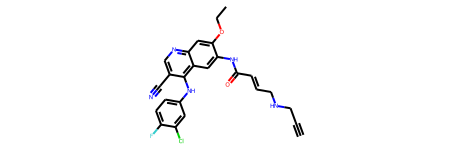

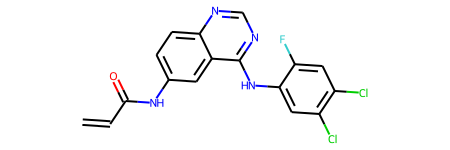

In [37]:
from rdkit import Chem as rdc
from IPython.display import display

for i in range(10):
    display(rdc.MolFromSmiles(compounds_df.iloc[i]["smiles"]))

The RDKit images can't be saved in a CSV file, so we will drop them again.

In [39]:
compounds_df.head(n=10)

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879
1,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849
2,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849
3,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910
4,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910
5,CHEMBL176582,0.010,nM,Cn1cnc2cc3ncnc(Nc4cccc(Br)c4)c3cc21,11.000000
6,CHEMBL29197,0.025,nM,COc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OC,10.602060
7,CHEMBL174426,0.025,nM,Cn1cnc2cc3c(Nc4cccc(Br)c4)ncnc3cc21,10.602060
8,CHEMBL1243316,0.030,nM,C#CCNC/C=C/C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N...,10.522879
9,CHEMBL363815,0.037,nM,C=CC(=O)Nc1ccc2ncnc(Nc3cc(Cl)c(Cl)cc3F)c2c1,10.431798


### 6. Save the Final Result

Now that we have done all that work to generate a nice table of compounds, let's save the result as a CSV file.

First, let's create a directory where our data will be stored.

In [44]:
import os

# Get the current working directory
os.getcwd()

# Create a data directory inside it
data_path = os.path.join(os.getcwd(), "data")

# If this directory doesn't already exist, create it
if not os.path.exists(data_path):
    os.mkdir(data_path)

Finally, write the DataFrame to a CSV file in our data directory.

In [46]:
compounds_file_path = os.path.join(data_path, "EGFR_compounds.csv")
compounds_df.to_csv(compounds_file_path)
print(f"Saved to {compounds_file_path}")

Saved to /home/avcopan/Documents/repos/cadd/cadd-practice/data/EGFR_compounds.csv
